<a href="https://colab.research.google.com/github/Alistar542/Algorithm_Theory/blob/master/personality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from sklearn.base import clone
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import plotly.graph_objects as px
from plotly import graph_objects as go
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# For mounting google drive. Can be removed when accessing the file from local system
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
regex = r"(\:(\w|\+|\-)+\:)(?=|[\!\.\?]|$)"
positive=[
	':cool:',
	':proud:',
	':ninja:',
	':kitteh:',
	':hampster:',
	':adoration:',
	':hearteyes:',
	':smiley-cool13:',
	':cheers2:',
	':eagerness:',
	':eek:',
	':angel:',
	':winky:',
	':biggrin:',
]

sad = [
	':sad:',
	':crying:',
	':tranquillity:',
]

happy = [
	':laughing:',
	':tongue:',
	':blushed:',
	':joyous:',
	':wink:',
	':th_wink:',
]

neutral = [
	':dry:',
	':mellow:',
	':carrot:',
	':brocoli:',
	':welcome:',
	':smile-new:',
	':puffer:',
	':emmersed:',
]

negative = [
	':suspicion:',
	':tranquillity:',
	':rolldeyes:',
]

feature_vectors = [
		'excl_per_comment',
		'ellipsis_per_comment',	
		'colon_per_comment',
		'link_per_comment',
		'image_per_comment',
		'question_per_comment',
		'wordCount',	
		'neg',	
		'neu',	
		'pos',	
		'com',	
		'num_nouns',	
		'num_verbs',
		'happy_emoji_per_comment',
		'sad_emoji_per_comment',
		'positive_emoji_per_comment',
		'negative_emoji_per_comment',
		'neutral_emoji_per_comment',
		'all_emoji'
]

tags_dict = {
    "NOUN": ["NN", "NNS", "NNP", "NNPS"],
    "VERB": ["MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
}

In [ ]:
#mbti_data = pd.read_csv('mbti_1.csv')
mbti_data = pd.read_csv('drive/MyDrive/DS/mbti_1.csv')
mbti_data.head()

FileNotFoundError: ignored

**Initial Visualization**

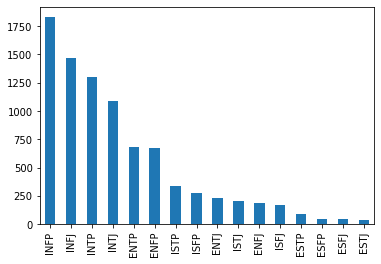

In [ ]:
mbti_data["type"].value_counts().plot(kind="bar")
plt.show()

**Data cleaning and Processing**

In [ ]:
# Method for cleaning the comments and generating pos_tags
def clean_data(text):
  # To replace ||| to ''
  text = text.replace('|||', ' ')
  # To replace ...
  text = text.replace('...', ' ')
  # To lower the case
  text = text.lower()
  # To remove the http links
  text = re.sub(r'http\S+', '', text)
  # To remove emails
  text = re.sub(r'\S*@\S*\s?', '', text)
  # To remove punctuations
  text = re.sub(r'[^a-z\s]', ' ', text)
  # To remove numbers
  text = ''.join([i for i in text if not i.isdigit()])
  # To remove extra space
  text = " ".join(text.split())
  # To remove repeating exclamations
  text = re.sub(r'(!)1+', '', text)
  # Fetching the stop words
  stop_words = stopwords.words('english')
  # Removing the stop words from the text
  filtered_sentence = [w for w in text.split(" ") if not w.lower() in stop_words]
  # Removing words less than length of 2
  filtered_sentence = [f for f in filtered_sentence if len(f) > 2]
  # Remove mbti types
  mbti_types = mbti_data["type"].unique()
  mbti_types = list(map(lambda x: x.lower(), mbti_types))
  filtered_sentence = [f for f in filtered_sentence if f not in mbti_types]
  # Perform Lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatized_post = [lemmatizer.lemmatize(f) for f in filtered_sentence]
  # Find the pos_tags for the text
  pos_tags = nltk.pos_tag(lemmatized_post)

  return lemmatized_post, pos_tags

In [ ]:
# Method for calculating sentiments for the comments
def calculate_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  score = analyzer.polarity_scores(text)
  return score

In [ ]:
# Method for calculating the length of tags
def number_of_tags(posTags,tag):
    num_tags = []
    for p in posTags:
        num_tags.append(len([word for word,pos in p if pos in tags_dict[tag]]))
    return num_tags

In [ ]:
#By Abby
def get_emoji_on_type(inpt,emoji_type):
    r = re.finditer(regex,inpt,re.IGNORECASE | re.MULTILINE)
    outpt = 0
    for emoji in r:
            if emoji.group() in emoji_type:
                outpt+=1
    return outpt

In [ ]:
#By Abby
def get_all_emojis(inpt):
    r = re.finditer(regex,inpt,re.IGNORECASE | re.MULTILINE)
    outpt = 0
    for i in r:
        outpt+=1
    return outpt

In [ ]:
# Calculate cleaned_post
cleaned_post = mbti_data['posts'].apply(lambda x : clean_data(x))
cleaned_data,pos_tags = list(zip(*cleaned_post))
mbti_data['cleaned_post'] = [' '.join(x) for x in cleaned_data]

In [ ]:
# Calculate sentiments for the data
sentiments = mbti_data['cleaned_post'].apply(lambda x : calculate_sentiment(x))

mbti_data['neg'] = [x['neg'] for x in sentiments]
mbti_data['neu'] = [x['neu'] for x in sentiments]
mbti_data['pos'] = [x['pos'] for x in sentiments]
mbti_data['com'] = [x['compound'] for x in sentiments]

In [ ]:
# Calculate num_nouns, num_verbs
mbti_data['num_nouns'] = number_of_tags(pos_tags,"NOUN")
mbti_data['num_nouns'] = mbti_data['num_nouns']/50
mbti_data['num_verbs'] = number_of_tags(pos_tags,"VERB")
mbti_data['num_verbs'] = mbti_data['num_verbs']/50

In [ ]:
# Calculate emoji score
mbti_data['happy_emoji_per_comment'] = mbti_data['posts'].apply(lambda x : get_emoji_on_type(x,happy)/50)
mbti_data['sad_emoji_per_comment'] = mbti_data['posts'].apply(lambda x : get_emoji_on_type(x,sad)/50)
mbti_data['positive_emoji_per_comment'] = mbti_data['posts'].apply(lambda x : get_emoji_on_type(x,positive)/50)
mbti_data['negative_emoji_per_comment'] = mbti_data['posts'].apply(lambda x :get_emoji_on_type(x,negative)/50)
mbti_data['neutral_emoji_per_comment'] = mbti_data['posts'].apply(lambda x : get_emoji_on_type(x,neutral)/50)
mbti_data['all_emoji'] = mbti_data['posts'].apply(lambda x :get_all_emojis(x)/50)

In [ ]:
# Calculate other parameters
mbti_data['image_per_comment'] = mbti_data['posts'].apply(lambda x: x.count('jpg')/50)
mbti_data['link_per_comment'] = mbti_data['posts'].apply(lambda x: x.count('http')/50)
mbti_data['question_per_comment'] = mbti_data['posts'].apply(lambda x: x.count('?')/50)
mbti_data['excl_per_comment'] = mbti_data['posts'].apply(lambda x: x.count('!')/50)
mbti_data['ellipsis_per_comment'] = mbti_data['posts'].apply(lambda x: x.count('...')/50)
mbti_data['colon_per_comment'] = mbti_data['posts'].apply(lambda x: x.count(':')/50)
mbti_data['wordCount'] = mbti_data['cleaned_post'].apply(lambda x: len(x.split()))

In [ ]:
mbti_data.head()

,type,posts,cleaned_post,neg,neu,pos,com,num_nouns,num_verbs,happy_emoji_per_comment,...,negative_emoji_per_comment,neutral_emoji_per_comment,all_emoji,image_per_comment,link_per_comment,question_per_comment,excl_per_comment,ellipsis_per_comment,colon_per_comment,wordCount
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank life ch...,0.132,0.595,0.272,0.9924,2.68,1.30,0.00,...,0.0,0.0,0.06,0.12,0.48,0.36,0.06,0.30,0.68,293
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring position...,0.121,0.588,0.291,0.9987,4.28,2.42,0.00,...,0.0,0.0,0.00,0.02,0.20,0.10,0.00,0.38,0.56,525
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...,0.118,0.574,0.309,0.9985,3.36,1.70,0.00,...,0.0,0.0,0.00,0.00,0.10,0.24,0.08,0.26,0.38,414
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gabbing...,0.089,0.655,0.256,0.9984,3.66,2.22,0.00,...,0.0,0.0,0.00,0.00,0.04,0.22,0.06,0.52,0.10,493
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,0.195,0.535,0.270,0.9884,3.56,2.20,0.02,...,0.0,0.0,0.02,0.04,0.12,0.20,0.02,0.42,0.28,452


**Training the model**

In [ ]:
def train_model(model, X_train,X_test,y_train,y_test, model_name):
  model.fit(X_train, y_train)
  accuracy = round(model.score(X_test, y_test) * 100, 2)
  print(f"Accuracy for the {model_name} model: {accuracy} %")

In [ ]:
ignored_fields = ['type','posts','cleaned_post']
X = mbti_data.drop(ignored_fields, axis=1).values
y = mbti_data['type'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

In [ ]:
random_forest = RandomForestClassifier()
train_model(random_forest,X_train,X_test,y_train,y_test,'Random Forest')

Accuracy for the Random Forest model: 22.54 %


In [ ]:
knn = KNeighborsClassifier(n_neighbors = 41) # 41 is sqrt(x_test)
train_model(knn,X_train,X_test,y_train,y_test,'K Nearest Neighbour')

Accuracy for the K Nearest Neighbour model: 19.31 %


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
train_model(pipe,X_train,X_test,y_train,y_test,'Logistic regression')

Accuracy for the Logistic regression model: 25.82 %


In [ ]:
ann = MLPClassifier(hidden_layer_sizes=(150,100,50), random_state=555, max_iter=300)
train_model(ann,X_train,X_test,y_train,y_test,'Artifical Neural Networks')

Accuracy for the Artifical Neural Networks model: 22.25 %


In [ ]:
gnb = GaussianNB()
train_model(gnb,X_train,X_test,y_train,y_test,'Naive Bayes')

Accuracy for the Naive Bayes model: 16.31 %


In [ ]:
svclassifier = SVC(kernel='linear')
train_model(svclassifier,X_train,X_test,y_train,y_test,'Support Vector')

**Categorizing into the I_E, N_S, T_F, J_P** \\
Introvert  -  Extrovert = I_E \\
Intuition  -  Sensing   = N_S \\
Feeling    -  Thinking  = T_F \\
Perceiving -  Judging   = J_P 

In [ ]:
def find_type_val(type):
  if type == 'I' or type == 'N' or type == 'T'or type == 'J':
    return 0
  if type == 'E' or type == 'S' or type == 'F'or type == 'P':
    return 1

In [ ]:
mbti_data['I_E'] = mbti_data['type'].apply(lambda x : find_type_val(x[0]))
mbti_data['N_S'] = mbti_data['type'].apply(lambda x : find_type_val(x[1]))
mbti_data['T_F'] = mbti_data['type'].apply(lambda x : find_type_val(x[2]))
mbti_data['J_P'] = mbti_data['type'].apply(lambda x : find_type_val(x[3]))

In [ ]:
def create_train_test_data(removal_list,y_label):
  X = mbti_data.drop(removal_list, axis=1).values
  y = mbti_data[y_label].values
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=5)
  return X_train,X_test,y_train,y_test

In [ ]:
removal_list = ['type','posts','cleaned_post','I_E','N_S','T_F','J_P',
                'happy_emoji_per_comment', 'sad_emoji_per_comment', 'positive_emoji_per_comment', 
                'negative_emoji_per_comment', 'neutral_emoji_per_comment']

X_IE_train,X_IE_test,y_IE_train,y_IE_test = create_train_test_data(removal_list,'I_E')

# Intuition vs Sensing
X_NS_train,X_NS_test,y_NS_train,y_NS_test = create_train_test_data(removal_list,'N_S')

# Thinking - Feeling
X_TF_train,X_TF_test,y_TF_train,y_TF_test = create_train_test_data(removal_list,'T_F')

# Judging - Percieiving
X_JP_train,X_JP_test,y_JP_train,y_JP_test = create_train_test_data(removal_list,'J_P')

In [ ]:
def train_model_individual(model,X_train,X_test,y_train,y_test,model_name):
  model.fit(X_train, y_train)
  accuracy = round(model.score(X_test, y_test) * 100, 2)
  print(f"Accuracy for the {model_name} model: {accuracy} %")
  return model,accuracy

In [ ]:
def train_all_models(model,model_name):
  IE_Model = model
  NS_Model = clone(model)
  TF_Model = clone(model)
  JP_Model = clone(model)
  IE_Model,IE_accuracy = train_model_individual(IE_Model,X_IE_train,X_IE_test,y_IE_train,y_IE_test,"I_E "+model_name)
  NS_Model,NS_accuracy = train_model_individual(NS_Model,X_NS_train,X_NS_test,y_NS_train,y_NS_test,"N_S "+model_name)
  TF_Model,TF_accuracy = train_model_individual(TF_Model,X_TF_train,X_TF_test,y_TF_train,y_TF_test,"T_F "+model_name)
  JP_Model,JP_accuracy = train_model_individual(JP_Model,X_JP_train,X_JP_test,y_JP_train,y_JP_test,"J_P "+model_name)

  mean_accuracy = round((IE_accuracy + NS_accuracy + TF_accuracy + JP_accuracy)/4, 2)

  print(f"Mean Accuracy of {model_name} model: {mean_accuracy} %")

  len_X_test = len(X_IE_test)
  predicted = np.concatenate((np.array(IE_Model.predict(X_IE_test)),
                              np.array(NS_Model.predict(X_NS_test)),
                              np.array(TF_Model.predict(X_TF_test)),
                              np.array(JP_Model.predict(X_JP_test))))
  predicted = np.reshape(predicted,(len_X_test,4))

  y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
  y_total = np.reshape(y_total,(len_X_test,4))

  acc = predicted == y_total
  complete = np.sum(acc,axis=1)
  total_accuracy = round((sum(complete == 4) / records_count)*100, 2)

  print(f"Total Accuracy for {model_name} model: {total_accuracy} %")

  return [IE_accuracy,NS_accuracy,TF_accuracy,JP_accuracy,mean_accuracy,total_accuracy]

In [ ]:
ANN_Model = MLPClassifier(hidden_layer_sizes=(150,100,50),learning_rate='adaptive', random_state=555, max_iter=1000)
ANN_evaluations = train_all_models(ANN_Model,'Artificial neural networks')

Accuracy for the I_E Artificial neural networks model: 77.64 %
Accuracy for the N_S Artificial neural networks model: 86.86 %
Accuracy for the T_F Artificial neural networks model: 45.07 %
Accuracy for the J_P Artificial neural networks model: 58.39 %
Mean Accuracy of Artificial neural networks model: 66.99 %
Total Accuracy for Artificial neural networks model: 28.01 %


In [ ]:
random_forest = RandomForestClassifier()
random_forest_evaluations = train_all_models(random_forest,'Random Forest')

Accuracy for the I_E Random Forest model: 77.0 %
Accuracy for the N_S Random Forest model: 86.74 %
Accuracy for the T_F Random Forest model: 65.42 %
Accuracy for the J_P Random Forest model: 57.29 %
Mean Accuracy of Random Forest model: 71.61 %
Total Accuracy for Random Forest model: 30.95 %


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 41)
knn_evaluations = train_all_models(knn_model,'K Nearest Neighbour')

Accuracy for the I_E K Nearest Neighbour model: 77.64 %
Accuracy for the N_S K Nearest Neighbour model: 86.86 %
Accuracy for the T_F K Nearest Neighbour model: 54.52 %
Accuracy for the J_P K Nearest Neighbour model: 58.56 %
Mean Accuracy of K Nearest Neighbour model: 69.4 %
Total Accuracy for K Nearest Neighbour model: 29.8 %


In [ ]:
log_model = LogisticRegression(solver='lbfgs', max_iter=1000)
log_reg_evaluations = train_all_models(log_model,'Logistic regression')

Accuracy for the I_E Logistic regression model: 77.41 %
Accuracy for the N_S Logistic regression model: 86.86 %
Accuracy for the T_F Logistic regression model: 66.97 %
Accuracy for the J_P Logistic regression model: 60.12 %
Mean Accuracy of Logistic regression model: 72.84 %
Total Accuracy for Logistic regression model: 33.49 %


In [ ]:
gnb_model = GaussianNB()
naive_bayes_evaluations = train_all_models(gnb_model,'Logistic regression')

Accuracy for the I_E Logistic regression model: 74.7 %
Accuracy for the N_S Logistic regression model: 81.67 %
Accuracy for the T_F Logistic regression model: 64.27 %
Accuracy for the J_P Logistic regression model: 57.12 %
Mean Accuracy of Logistic regression model: 69.44 %
Total Accuracy for Logistic regression model: 25.48 %


In [ ]:
svclassifier = SVC(kernel='linear')
svc_evaluations = train_all_models(svclassifier,'SVC Classifier')

Accuracy for the I_E SVC Classifier model: 77.58 %
Accuracy for the N_S SVC Classifier model: 86.86 %
Accuracy for the T_F SVC Classifier model: 66.97 %
Accuracy for the J_P SVC Classifier model: 60.29 %
Mean Accuracy of SVC Classifier model: 72.92 %
Total Accuracy for SVC Classifier model: 33.26 %


In [ ]:
# bars1 = [acc_ANN_IE , acc_ANN_NS , acc_ANN_TF , acc_ANN_JP, mean_acc_ann, act_acc_ann]
# bars2 = [acc_random_forest_IE , acc_random_forest_NS , acc_random_forest_TF , acc_random_forest_JP, mean_acc_random_forest, act_rf_ann]
# bars3 = [acc_knn_IE , acc_knn_NS , acc_knn_TF , acc_knn_JP, mean_acc_knn, act_knn_ann]
# bars4 = [acc_log_IE , acc_log_NS , acc_log_TF , acc_log_JP, mean_acc_log, act_log_ann]
# bars5 = [acc_nb_IE , acc_nb_NS , acc_nb_TF , acc_nb_JP, mean_acc_gnb, act_nb_ann]
# bars6 = [acc_svc_IE , acc_svc_NS , acc_svc_TF , acc_svc_JP, mean_acc_svc, act_svc_ann]

x = ['I-E', 'N-S', 'T-F', 'J-P', 'mean', 'actual']
  
plot = px.Figure(data=[
    go.Bar(name = 'ANN', x = x, y = ANN_evaluations),
    go.Bar(name = 'Random Forest', x = x, y = random_forest_evaluations),
    go.Bar(name = 'KNN', x = x, y = knn_evaluations),
    go.Bar(name = 'Logistic Regression', x = x, y = log_reg_evaluations),
    go.Bar(name = 'Naive Bayes', x = x, y = naive_bayes_evaluations),
    go.Bar(name = 'SVM', x = x, y = svc_evaluations),
])
                   
plot.show()

Using count vectorizer

In [ ]:
cv = CountVectorizer().fit(mbti_data['cleaned_post'])
X = cv.transform(mbti_data['cleaned_post'])

In [ ]:
xIETrain, xIETest, yIETrain, yIETest = train_test_split(X, mbti_data['I_E'])
xNSTrain, xNSTest, yNSTrain, yNSTest = train_test_split(X, mbti_data['N_S'])
xFTTrain, xFTTest, yFTTrain, yFTTest = train_test_split(X, mbti_data['T_F'])
xPJTrain, xPJTest, yPJTrain, yPJTest = train_test_split(X, mbti_data['J_P'])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
ieModel = MultinomialNB().fit(xIETrain, yIETrain)
nsModel = MultinomialNB().fit(xNSTrain, yNSTrain)
ftModel = MultinomialNB().fit(xFTTrain, yFTTrain)
pjModel = MultinomialNB().fit(xPJTrain, yPJTrain)

In [ ]:
print(ieModel.score(xIETest, yIETest)*100)
print(nsModel.score(xNSTest, yNSTest)*100)
print(ftModel.score(xFTTest, yFTTest)*100)
print(pjModel.score(xPJTest, yPJTest)*100)

76.76348547717843
84.78561549100968
79.02259105578608
69.34071000461041


The code to the bottom can be removed

In [ ]:
#ANN
IE_Model = MLPClassifier(hidden_layer_sizes=(150,100,50),learning_rate='adaptive', random_state=555, max_iter=1000)
NS_Model = MLPClassifier(hidden_layer_sizes=(150,100,50),learning_rate='adaptive', random_state=555, max_iter=1000)
TF_Model = MLPClassifier(hidden_layer_sizes=(150,100,50),learning_rate='adaptive', random_state=555, max_iter=1000)
JP_Model = MLPClassifier(hidden_layer_sizes=(150,100,50),learning_rate='adaptive', random_state=555, max_iter=1000)

model_name = 'Artificial neural networks'
IE_Model,IE_ANN_accuracy = train_model_individual(IE_Model,X_IE_train,X_IE_test,y_IE_train,y_IE_test,model_name)
NS_Model,NS_ANN_accuracy = train_model_individual(NS_Model,X_NS_train,X_NS_test,y_NS_train,y_NS_test,model_name)
TF_Model,TF_ANN_accuracy = train_model_individual(TF_Model,X_TF_train,X_TF_test,y_TF_train,y_TF_test,model_name)
JP_Model,JP_ANN_accuracy = train_model_individual(JP_Model,X_JP_train,X_JP_test,y_JP_train,y_JP_test,model_name)

mean_ANN_accuracy = round((IE_ANN_accuracy + NS_ANN_accuracy + TF_ANN_accuracy + JP_ANN_accuracy)/4, 2)

print("mean Accuracy: ", mean_ANN_accuracy , "%")

#records_count = len(X_IE_test)

# predicted = np.concatenate((np.array(IEClass.predict(X_IE_test)),np.array(NSClass.predict(X_NS_test)),np.array(TFClass.predict(X_TF_test)),np.array(JPClass.predict(X_JP_test))))
# predicted = np.reshape(predicted,(records_count,4))

# y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
# y_total = np.reshape(y_total,(records_count,4))

# acc = predicted == y_total
# complete = np.sum(acc,axis=1)
# act_acc_ann = round((sum(complete == 4) / records_count)*100, 2)

# print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")

I-E Accuracy:  77.64 %
N-S Accuracy:  86.86 %
T-F Accuracy:  45.07 %
J-P Accuracy:  58.39 %
mean Accuracy:  66.99 %
Actuall Accuracy (pint to point):  28.01 %
1-miss Accuracy (pint to point):  59.31 %


In [ ]:
predicted = np.concatenate((np.array(IEClass.predict(X_IE_test)),np.array(NSClass.predict(X_NS_test)),np.array(TFClass.predict(X_TF_test)),np.array(JPClass.predict(X_JP_test))))
predicted = np.reshape(predicted,(records_count,4))
jk = predicted == y_total
np.sum(jk,axis=1)

array([3, 2, 4, ..., 2, 2, 3])

In [ ]:
random_forest = RandomForestClassifier()

# I-E
random_forest.fit(X_IE_train, y_IE_train)
acc_random_forest_IE = round(random_forest.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy: ", acc_random_forest_IE, "%")

iep = np.array(random_forest.predict(X_IE_test))

# N-S
random_forest.fit(X_IE_train, y_NS_train)
acc_random_forest_NS = round(random_forest.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy: ", acc_random_forest_NS, "%")

nsp = np.array(random_forest.predict(X_NS_test))

# T-F
random_forest.fit(X_TF_train, y_TF_train)
acc_random_forest_TF = round(random_forest.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy: ", acc_random_forest_TF, "%")

tfp = np.array(random_forest.predict(X_TF_test))

# J-P
random_forest.fit(X_JP_train, y_JP_train)
acc_random_forest_JP = round(random_forest.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy: ", acc_random_forest_JP, "%")

jpp = np.array(random_forest.predict(X_JP_test))

mean_acc_random_forest = (acc_random_forest_IE + acc_random_forest_NS + acc_random_forest_TF + acc_random_forest_JP)/4
print("mean Accuracy: ", mean_acc_random_forest , "%")



records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_rf_ann = round((sum(complete == 4) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_rf_ann, "%")

I-E Accuracy:  77.0 %
N-S Accuracy:  86.69 %
T-F Accuracy:  65.48 %
J-P Accuracy:  56.25 %
mean Accuracy:  71.355 %
Actuall Accuracy (pint to point):  30.55 %


In [ ]:
knn = KNeighborsClassifier(n_neighbors = 41)

# I-E
knn.fit(X_IE_train, y_IE_train)
acc_knn_IE = round(knn.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy: ", acc_knn_IE, "%")

iep = np.array(knn.predict(X_IE_test))

# N-S
knn.fit(X_NS_train, y_NS_train)
acc_knn_NS = round(knn.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy: ", acc_knn_NS, "%")

nsp = np.array(knn.predict(X_NS_test))

# T-F
knn.fit(X_TF_train, y_TF_train)
acc_knn_TF = round(knn.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy: ", acc_knn_TF, "%")

tfp = np.array(knn.predict(X_TF_test))

# J-P
knn.fit(X_JP_train, y_JP_train)
acc_knn_JP = round(knn.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy: ", acc_knn_JP, "%")

jpp = np.array(knn.predict(X_JP_test))

mean_acc_knn = (acc_knn_IE + acc_knn_NS + acc_knn_TF + acc_knn_JP)/4
print("mean Accuracy: ", mean_acc_knn , "%")


records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_knn_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy:  77.64 %
N-S Accuracy:  86.86 %
T-F Accuracy:  54.35 %
J-P Accuracy:  58.04 %
mean Accuracy:  69.2225 %
Actuall Accuracy (pint to point):  31.59 %
1-miss Accuracy (pint to point):  61.9 %


In [ ]:
log = LogisticRegression(solver='lbfgs', max_iter=1000)

# I-E
log.fit(X_IE_train, y_IE_train)
acc_log_IE = round(log.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy: ", acc_log_IE, "%")

iep = np.array(log.predict(X_IE_test))

# N-S
log.fit(X_NS_train, y_NS_train)
acc_log_NS = round(log.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy: ", acc_log_NS, "%")

nsp = np.array(log.predict(X_NS_test))

# T-F
log.fit(X_TF_train, y_TF_train)
acc_log_TF = round(log.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy: ", acc_log_TF, "%")

tfp = np.array(log.predict(X_TF_test))

# J-P
log.fit(X_JP_train, y_JP_train)
acc_log_JP = round(log.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy: ", acc_log_JP, "%")

jpp = np.array(log.predict(X_JP_test))

mean_acc_log = (acc_log_IE + acc_log_NS + acc_log_TF + acc_log_JP)/4
print("mean Accuracy: ", mean_acc_log , "%")

records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_log_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy:  77.18 %
N-S Accuracy:  86.86 %
T-F Accuracy:  67.26 %
J-P Accuracy:  60.17 %
mean Accuracy:  72.8675 %
Actuall Accuracy (pint to point):  31.59 %
1-miss Accuracy (pint to point):  68.3 %


In [ ]:
gnb = GaussianNB()

# I-E
gnb.fit(X_IE_train, y_IE_train)
acc_nb_IE = round(gnb.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy:", acc_nb_IE, "%")

iep = np.array(gnb.predict(X_IE_test))

# N-S
gnb.fit(X_NS_train, y_NS_train)
acc_nb_NS = round(gnb.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy:", acc_nb_NS, "%")

nsp = np.array(gnb.predict(X_NS_test))

# T-F
gnb.fit(X_TF_train, y_TF_train)
acc_nb_TF = round(gnb.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy:", acc_nb_TF, "%")

tfp = np.array(gnb.predict(X_TF_test))

# J-P
gnb.fit(X_JP_train, y_JP_train)
acc_nb_JP = round(gnb.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy:", acc_nb_JP, "%")

jpp = np.array(gnb.predict(X_JP_test))

mean_acc_gnb = (acc_nb_IE + acc_nb_NS + acc_nb_TF + acc_nb_JP)/4
print("mean Accuracy: ", mean_acc_gnb , "%")


records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_nb_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy: 75.27 %
N-S Accuracy: 81.96 %
T-F Accuracy: 65.59 %
J-P Accuracy: 56.95 %
mean Accuracy:  69.9425 %
Actuall Accuracy (pint to point):  31.59 %
1-miss Accuracy (pint to point):  65.88 %


In [ ]:
svclassifier = SVC(kernel='linear')

# I-E
svclassifier.fit(X_IE_train, y_IE_train)
acc_svc_IE = round(svclassifier.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy:", acc_nb_IE, "%")

iep = np.array(svclassifier.predict(X_IE_test))

# N-S
svclassifier.fit(X_NS_train, y_NS_train)
acc_svc_NS = round(svclassifier.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy:", acc_nb_NS, "%")

nsp = np.array(svclassifier.predict(X_NS_test))

# T-F
svclassifier.fit(X_TF_train, y_TF_train)
acc_svc_TF = round(svclassifier.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy:", acc_nb_TF, "%")

tfp = np.array(svclassifier.predict(X_TF_test))

# J-P
svclassifier.fit(X_JP_train, y_JP_train)
acc_svc_JP = round(svclassifier.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy:", acc_nb_JP, "%")

jpp = np.array(svclassifier.predict(X_JP_test))

mean_acc_svc = (acc_nb_IE + acc_nb_NS + acc_nb_TF + acc_nb_JP)/4
print("mean Accuracy: ", mean_acc_svc , "%")


records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_svc_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy: 75.27 %
N-S Accuracy: 81.96 %
T-F Accuracy: 65.59 %
J-P Accuracy: 56.95 %
mean Accuracy:  69.9425 %
Actuall Accuracy (pint to point):  31.59 %
1-miss Accuracy (pint to point):  67.84 %
